# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We set seed to better reproduce results later on.
#np.random.seed(12345)

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [273]:
def activate(inputs, activation_function):
    if activation_function == "relu":
        return np.maximum(0, inputs)
    elif activation_function == "elu":
        alpha = 1
        return np.where(inputs > 0, inputs, alpha * (np.exp(inputs) - 1))
    return inputs

In [274]:
# TODO Test your activation functions, is the returning values what you expect?
print(activate(4, activation_function="elu"))

4.0


### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [275]:
# ReLU: https://stats.stackexchange.com/questions/333394/what-is-the-derivative-of-the-relu-activation-function
# ELU:  https://medium.com/@krishnakalyan3/introduction-to-exponential-linear-unit-d3e2904b366c
def d_activate(inputs, activation_function):
    if activation_function == "relu":
        return np.where(inputs > 0, 1.0, 0)
    elif activation_function == "elu":
        alpha = 1.0
        return np.where(inputs > 0, 1.0, alpha * np.exp(inputs))
    return np.ones_like(inputs)

In [276]:
# TODO Test your activation function derivatives, is the returning values what you expect?
print(d_activate(4, activation_function="elu"))
print(d_activate(4, activation_function="relu"))

test_array = np.array([-1, 5, -42, -1, 8])
print(d_activate(test_array, activation_function="elu"))
print(d_activate(test_array, activation_function="relu"))

1.0
1.0
[3.67879441e-01 1.00000000e+00 5.74952226e-19 3.67879441e-01
 1.00000000e+00]
[0. 1. 0. 0. 1.]


### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [277]:
# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y): # y_hat = predictions, y = the real values (targets)
    y_hat = np.array(y_hat)
    y = np.array(y)
    loss = np.mean(np.clip(np.square(y - y_hat), 1e-10, 1e10))
    return loss

y_h = [2,3,4,5]
y = [1,1,1,1]

print(MSE_loss(y_h,y))

# TODO: Choose another loss function and implement it
def MAE_loss(y_hat, y):
    y_hat = np.array(y_hat)
    y = np.array(y)
    loss = np.mean(np.abs(np.subtract(y, y_hat)))
    return loss


def cross_entropy_loss(y_hat, y):
    return -np.mean(np.sum(y * np.log(y_hat + 1e-10), axis=1))  # Prevent log(0) errors

def d_cross_entropy_loss(y_hat, y):
    return y_hat - y  # Softmax derivative simplifies to this


7.5


The derivatives of the loss is with respect to the predicted value **y_hat**.

In [278]:
def d_MSE_loss(y_hat, y): # y_hat = predictions, y = the real values (targets)
    y_hat = np.array(y_hat)
    y = np.array(y)
    dy = (2 / len(y_hat)) * np.subtract(y, y_hat)
    return dy

# TODO: Choose another loss function and implement it
def d_MAE_loss(y_hat, y):
    y_hat = np.array(y_hat)
    y = np.array(y)
    dy = np.sign(y_hat - y) / len(y_hat)  # Compute sign and normalize
    return dy


### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [279]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def propagate_forward(weights, activations, biases, activation_function):
    z = np.dot(activations, weights) + biases.T
    if activation_function == "softmax":
        return softmax(z)
    return activate(z, activation_function)


### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [280]:
# Calculates the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights and the input signal (activations).

def propagate_backward(weights, activations, dl_dz, biases, activation_function="none"):
    # NOTE: dl_dz is the derivative of the loss based on the previous layers activations/outputs
    
    dot_product = np.dot(activations, weights) + biases.T  # Transpose bias to match the shape of dot_product
    d_loss = d_activate(dot_product, activation_function) * dl_dz
    d_weights = np.dot(activations.T, d_loss)
    d_activations = np.dot(d_loss, weights.T)
    d_biases = np.sum(d_loss, axis=0, keepdims=True).T
    return d_weights, d_biases, d_activations

## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [281]:
# MLP = Multi Layer Perceptron Neural Network
class NeuralNet(object):
    
    # Setup all parameters and activation functions.
    # This function runs directly when a new instance of this class is created. 
    # Input_dim is the size of the input (number of features?), output_dim is the size of the output (number of classes) and neurons is a list of the number of neurons in each layer.
    def __init__ (self, input_dim, output_dim, neurons = []):
        # NOTE: The "neurons" parameter is given as a list.
        # E.g., [4, 8, 4] means 4 neurons in layer 1, 8 neurons in layer 2 etc...

        # TODO: Add support for bias for each neuron in the code below.
        self.weights = [0.01 * np.random.randn(n, m) for n, m in zip([input_dim] + neurons, neurons + [output_dim])]
        self.biases = [0.01 * np.random.randn(n, 1) for n in neurons + [output_dim]]
        self.activation_functions = ["relu"] * len(neurons) + ["softmax"]

    
    # Predict the input throught the network and calculate the output.
    def forward(self, x):
        """ x is the input to the network, or to the next layer. """
        # TODO: Add support for a bias for each neuron in the code below.
        for layer_weights, layer_biases, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            x = propagate_forward(layer_weights, x, layer_biases, layer_activation_function)
            
        return x
    
    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    # The weight updates are happening "in-place", thus we are only returning the loss from this function.
    # Note that this function can handle a variable size of the input (x), both full datasets or smaller parts of the dataset.
    def adjust_weights(self, x, y, learning_rate=1e-4):
        activation = x
        activation_history = []
        for layer_weights, layer_biases, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation_history.append(activation)
            activation = propagate_forward(layer_weights, activation, layer_biases, layer_activation_function)
        
        # loss = MSE_loss(activation, y)
        # d_activations = d_MSE_loss(activation, y)

        loss = cross_entropy_loss(activation, y)
        d_activations = d_cross_entropy_loss(activation, y)

        
        for i in reversed(range(len(self.weights))):
            d_weights, d_biases, d_activations = propagate_backward(self.weights[i], activation_history[i], d_activations, self.biases[i], self.activation_functions[i])
            d_weights = np.clip(d_weights, -1, 1)
            d_biases = np.clip(d_biases, -1, 1)

            self.weights[i] -= learning_rate * d_weights
            self.biases[i] -= learning_rate * d_biases
                    
        return loss
    
    # A function for the training of the network.
    def train_net(self, x, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=True):
        if use_validation_data:
            split_index = int(0.8 * len(x))
            x_train, x_val = x[:split_index], x[split_index:]
            y_train, y_val = y[:split_index], y[split_index:]
        else:
            x_train, y_train = x, y
        
        epoch_losses = []
        for epoch in range(epochs):
            loss = 0
            for i in range(0, len(x_train), batch_size):
                loss += self.adjust_weights(x_train[i:i+batch_size], y_train[i:i+batch_size], learning_rate)
            epoch_losses.append(loss)
            print(f"Epoch {epoch}, Loss: {loss}")
            if use_validation_data:
                val_loss = MSE_loss(self.forward(x_val), y_val)
                print(f"Validation Loss: {val_loss}")
        
        return epoch_losses


    

## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

Epoch 0, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 1, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 2, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 3, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 4, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 5, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 6, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 7, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 8, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 9, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 10, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 11, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 12, Loss: -1.350108452792431e-09
Validation Loss: 193.3836712800902
Epoch 13, Loss: -1.350108452792431e-09
Validatio

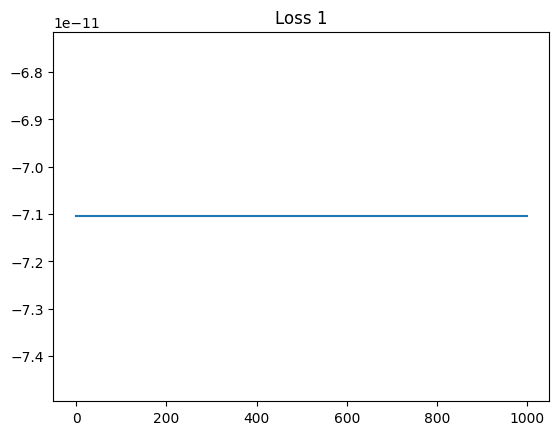

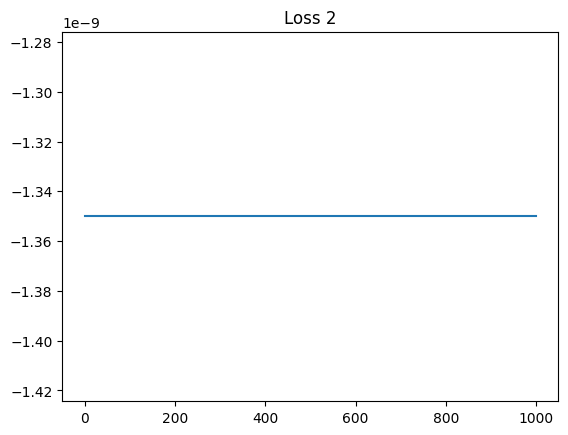

In [282]:
n = 1000
input_dimension = 4
output_dim = 1
neurons = [18, 12]  # NOTE: 18 neurons in layer 1, 12 neurons in layer 2 etc...

k = np.random.randint(0, 10, (input_dimension, 1))
x = np.random.normal(0, 1, (n, input_dimension))
y = np.dot(x, k) + 0.1 + np.random.normal(0, 0.01, (n, 1))

# Create an instance of the NeuralNet class
nn = NeuralNet(input_dimension, output_dim, neurons)

# Adjust weights using the adjust_weights function
loss_1 = [nn.adjust_weights(x, y) for _ in range(1000)]

# Train the network using the train_net function
loss_2 = nn.train_net(x, y, batch_size=32, epochs=1000, learning_rate=1e-4, use_validation_data=True)


# Plot the losses
plt.plot(loss_1)
plt.title("Loss 1")
plt.show()

plt.plot(loss_2)
plt.title("Loss 2")
plt.show()

### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

### 8) Dataset 1: Wine - with and without scaling

Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

Train two neural network, one with scaling and one without. Are we able to see any difference in training results or loss over time?

**Note:** Do not train for to many epochs (more than maybe 50-100). The network might "learn" anyway in the end, but you should still be able to see a difference when training.

Epoch 0, Loss: 4.4017462645252206
Validation Loss: 0.2227961828627894
Epoch 1, Loss: 4.401728784693257
Validation Loss: 0.22279480090269285
Epoch 2, Loss: 4.4017113102441146
Validation Loss: 0.22279341931611854
Epoch 3, Loss: 4.401693841175925
Validation Loss: 0.22279203810294282
Epoch 4, Loss: 4.401676377486822
Validation Loss: 0.222790657263042
Epoch 5, Loss: 4.401658919174942
Validation Loss: 0.22278927679629265
Epoch 6, Loss: 4.4016414662384165
Validation Loss: 0.22278789670257138
Epoch 7, Loss: 4.401624018675384
Validation Loss: 0.22278651698175456
Epoch 8, Loss: 4.401606576483981
Validation Loss: 0.22278513763371896
Epoch 9, Loss: 4.401589139662341
Validation Loss: 0.2227837586583412
Epoch 10, Loss: 4.401571708208607
Validation Loss: 0.22278238005549808
Epoch 11, Loss: 4.401554282120914
Validation Loss: 0.22278100182506627
Epoch 12, Loss: 4.401536861397403
Validation Loss: 0.22277962396692264
Epoch 13, Loss: 4.401519446036215
Validation Loss: 0.22277824648094413
Epoch 14, Loss: 4

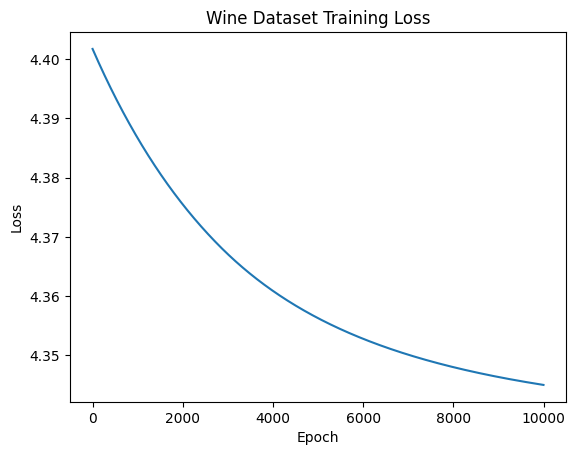

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the data
data_wine = pd.read_csv("wine.csv", skiprows=[1]).to_numpy()

# Normalize the input data
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(data_wine[:, :-1])
y = data_wine[:, -1]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# One-hot encode labels
encoder = preprocessing.OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Train and test your neural networks
input_dimension = X_train.shape[1]
output_dim = y_train.shape[1]
neurons = [18, 12]
nn_wine = NeuralNet(input_dimension, output_dim, neurons)
losses_wine = nn_wine.train_net(X_train, y_train, batch_size=32, epochs=10000, learning_rate=1e-5)
y_pred = np.round(nn_wine.forward(X_test))
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Wine Dataset Accuracy:", accuracy)
plt.plot(losses_wine)
plt.title("Wine Dataset Training Loss, hello")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Real data and hyper-parameter tuning

Now we are going to use real data, preprocess it, and do hyper-parameter tuning.

Choose two hyper-parameters to tune to try and achive an even better result.

**NOTE:** Changing the number of epochs should be part of the tuning, but it does not count towards the two hyper parameters.

### 9) Dataset 2: Mushroom

Mushroom dataset: https://archive.ics.uci.edu/dataset/73/mushroom

Note: This dataset has one feature with missing values. Remove this feature.

In [ ]:
data_mushroom = pd.read_csv("mushroom.csv").to_numpy()

# TODO: Preprocess the data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [ ]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

### 10) Dataset 3: Adult

Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

**IMPORTANT NOTE:** This dataset is much larger than the previous two (48843 instances). If your code runs slow on your own computer, you may exclude parts of this dataset, but you must keep a minimum of 10000 datapoints.

In [ ]:
dataset_3 = pd.read(...) # TODO: Read the data.

# TODO: Preprocess the data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

AttributeError: module 'pandas' has no attribute 'read'

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [ ]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why would we want to use different activation functions?

2) Why would we want to use different loss functions?

3) Why are neural networks sensitive to large input values?

4) What is the role of the bias? 

5) What is the purpose of hyper-parameter tuning?

6) A small example neural network will be shown during the oral examination. You will be asked a few basic questions related to the number of weights, biases, inputs and outputs.

If we don't apply an activation function, every node will just be a linear combination of every node before it (+ a bias term)

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!